In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
os.chdir(project_root)

if project_root not in sys.path:
    sys.path.append(project_root)

print("Current dir:", os.getcwd())

Current dir: /Users/ricardojuancardenesperez/tfg/framework


In [2]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

In [ ]:
from playground.readers.english_sentences_text_dataset_1.reader import Reader
from torch.utils.data import DataLoader

from playground.architectures.lstm_seq2seq_bidirectional_enc import (
    Builder,
    Wrapper
)

from playground.trainers import TextAnnealingTrainer

In [4]:
from omegaconf import OmegaConf
from dacite import from_dict, Config as DaciteConfig
from xlstm import xLSTMBlockStackConfig

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset

In [6]:
dataset = Reader()

In [7]:
for sample in dataset:
    print(sample)
    break

tensor([224, 213,  95, 261,  66,  24, 107, 142, 217, 166])


In [8]:
pad_idx = dataset.tokenizer.token2idx['<pad>']

In [9]:
def collate_fn(batch, max_len=30):
    global pad_idx
    batch = pad_sequence(batch, batch_first=True, padding_value=pad_idx)
    
    if batch.size(1) < max_len:
        pad_len = max_len - batch.size(1)
        pad_tensor = torch.full(
            (batch.size(0), pad_len, *batch.shape[2:]),
            fill_value=pad_idx,
            dtype=batch.dtype
        )
        batch = torch.cat([batch, pad_tensor], dim=1)
    
    return batch[:, :max_len]

In [10]:
from functools import partial

loader = DataLoader(dataset, batch_size=4, collate_fn=partial(collate_fn, max_len=30), shuffle=True)

In [11]:
for batch in loader:
    print(batch.shape)
    break

torch.Size([4, 30])


# Model

In [12]:
vocab_size = len(dataset.tokenizer.vocab)

In [13]:
builder = Builder()
model = builder.build(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_dim=64,
    latent_dim=10,
    context_length=30,
    num_layers=1
)

In [ ]:
wrapper = Wrapper(model)

In [15]:
x = torch.zeros(1, 12).long()
x, mu, sigma = wrapper(batch)
x.shape

torch.Size([4, 30, 342])

# Training

In [16]:
criteria = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
trainer = TextAnnealingTrainer(wrapper, 
                      criteria, 
                      optimizer, 
                      epochs=400,
                      batch_size=loader.batch_size,
                      method='logistic',
                      k=0.003,
                      x0=3800)

In [18]:
model, metrics = trainer.train(loader, teacher_forcing=0.5, return_metrics=True)

Epoch: 0, Loss: 582.0752446101262, Model Loss: 5.820744624504676, KD Loss: 67.63347992530235, KD Weight: 1.2067290052051435e-05
Epoch: 1, Loss: 566.4131751427284, Model Loss: 5.6641235168163595, KD Loss: 65.22581834059496, KD Weight: 1.3046207932684072e-05
Epoch: 2, Loss: 510.3722158578726, Model Loss: 5.103685709146353, KD Loss: 265.7987037071815, KD Weight: 1.4104536078308068e-05
Epoch: 3, Loss: 471.97824331430286, Model Loss: 4.719710074938261, KD Loss: 492.1413081242488, KD Weight: 1.52487160967462e-05
Epoch: 4, Loss: 454.1922595684345, Model Loss: 4.541843029168936, KD Loss: 500.9329106257512, KD Weight: 1.648571209472348e-05
Epoch: 5, Loss: 441.1633793757512, Model Loss: 4.411539206138024, KD Loss: 550.2427509014423, KD Weight: 1.782305305399329e-05
Epoch: 6, Loss: 429.4419731727013, Model Loss: 4.294313054818374, KD Loss: 575.1320695143479, KD Weight: 1.9268878643376507e-05
Epoch: 7, Loss: 421.0446049616887, Model Loss: 4.210318464499253, KD Loss: 634.5898695725662, KD Weight: 2

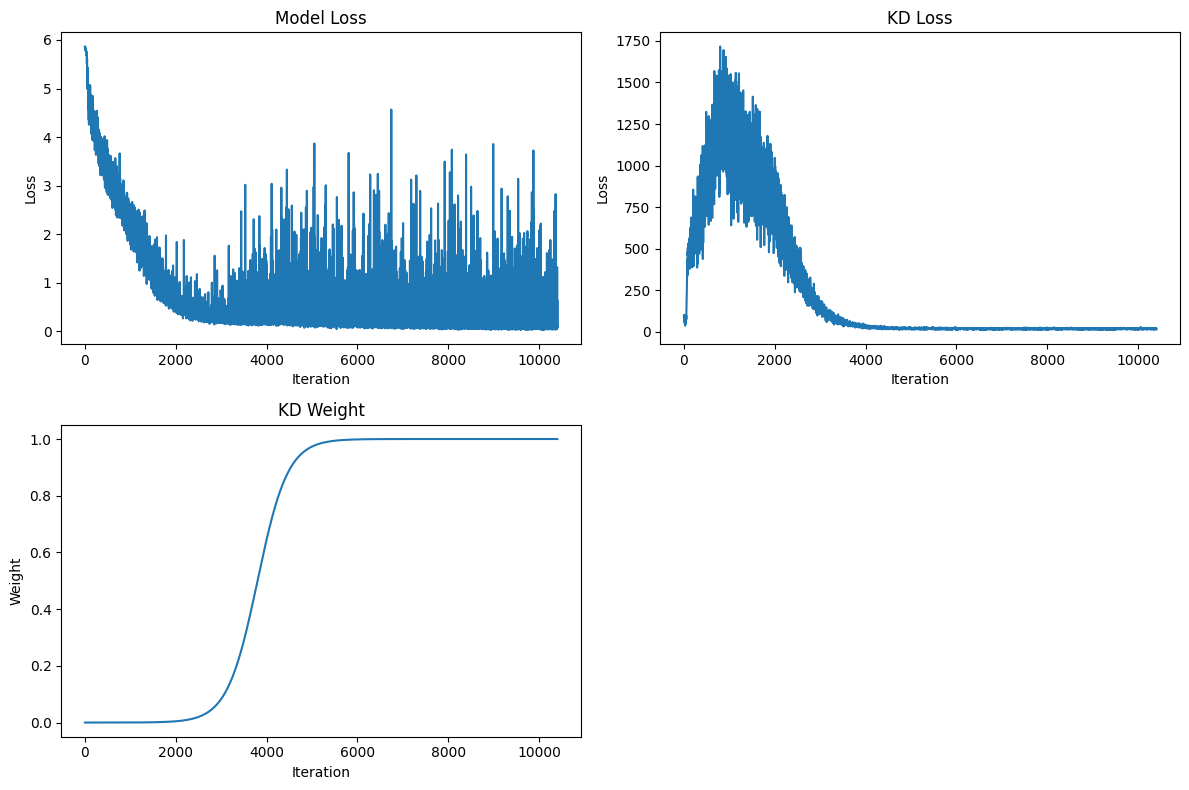

In [26]:
epochs = list(range(1, len(metrics['model_loss']) + 1))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(epochs, metrics['model_loss'])
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')

axes[0, 1].plot(epochs, metrics['kd_loss'])
axes[0, 1].set_title('KD Loss')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Loss')

axes[1, 0].plot(epochs, metrics['kd_weight'])
axes[1, 0].set_title('KD Weight')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Weight')

axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Performance

In [27]:
def transform_to_text(output):
    return ' '.join(dataset.tokenizer.decode(output.numpy().tolist()[0]))

In [28]:
count = 20
results = {'input': [], 'output': []}

for i, sentence in enumerate(dataset):
    input = sentence.unsqueeze(0)

    output, mu, sigma = model(input)
    output = output.argmax(dim=-1)
    
    input = transform_to_text(input)
    output = transform_to_text(output)

    results['input'].append(input)
    results['output'].append(output)

    print(f"Sample {i}")
    print("Original:", input[:-5])
    print("Reconstructed:", output.split("<eos>")[0])
    print()

    if count == 0:
        break

    count -= 1

Sample 0
Original: I usually get up around seven in the morning 
Reconstructed: I’ll send you the document tomorrow morning 

Sample 1
Original: She forgot to bring her umbrella again 
Reconstructed: She forgot to bring her umbrella again 

Sample 2
Original: We were talking about the trip last night 
Reconstructed: We should take a break and get some fresh air 

Sample 3
Original: He always leaves his keys on the kitchen table 
Reconstructed: He made a good impression on the team 

Sample 4
Original: They decided to try a new restaurant downtown 
Reconstructed: They decided to try a new restaurant downtown 

Sample 5
Original: Are you going to the meeting this afternoon 
Reconstructed: Are you going to the meeting this afternoon 

Sample 6
Original: I haven’t seen him since last summer 
Reconstructed: I couldn’t understand what he was saying 

Sample 7
Original: The coffee machine stopped working yesterday 
Reconstructed: The train leaves at exactly eight thirty 

Sample 8
Original: S

# Interpolation

In [29]:
z1 = torch.randn(1, 10)
z2 = torch.randn(1, 10)

In [30]:
output1 = model.model.decoder(z1)
output2 = model.model.decoder(z2)

output1 = output1.argmax(dim=-1)
output2 = output2.argmax(dim=-1)

output1 = transform_to_text(output1)
output2 = transform_to_text(output2)

In [31]:
print("First sentence:", output1.split('<eos>')[0])
print("Second sentence:", output2.split('<eos>')[0])

First sentence: The coffee machine stopped working yesterday 
Second sentence: We’ll talk about it after lunch 


In [32]:
num_steps = 10

for alpha in torch.linspace(0, 1, steps=num_steps):
    z_interp = (1 - alpha) * z1 + alpha * z2
    output = model.model.decoder(z_interp)
    output = output.argmax(dim=-1)
    text = transform_to_text(output)
    print(f"alpha={alpha:.2f} →", text.split('<eos>')[0])

alpha=0.00 → The coffee machine stopped working yesterday 
alpha=0.11 → The coffee machine stopped working yesterday 
alpha=0.22 → He often travels for work 
alpha=0.33 → He often travels for work 
alpha=0.44 → He often travels for work 
alpha=0.56 → He brought snacks for everyone 
alpha=0.67 → He brought snacks for everyone 
alpha=0.78 → We’ll talk about it after lunch 
alpha=0.89 → We’ll talk about it after lunch 
alpha=1.00 → We’ll talk about it after lunch 
